# Notebook Huấn luyện Mô hình Phân loại Tư thế
Notebook này sẽ lấy file `all_landmarks_labeled.csv` (đã được dán nhãn tự động) và huấn luyện một mô hình Machine Learning.

**Quy trình:**
1.  **Tải Dữ liệu:** Đọc file `all_landmarks_labeled.csv`.
2.  **Tiền xử lý:**
    * **Lọc (Filter):** Loại bỏ toàn bộ các hàng có nhãn `no_rep`.
    * **Tạo (Create) `X` (Features)**: Gồm 132 cột landmark (`lmk_...`).
    * **Tạo (Create) `y` (Target)**: Gồm cột `label` ("correct" / "incorrect").
    * **Mã hóa (Encode):** Chuyển nhãn "correct" / "incorrect" thành số (0 / 1).
3.  **Phân chia Dữ liệu (An toàn):**
    * Chia dữ liệu thành 3 tập (Train 60%, Val 20%, Test 20%).
    * **Quan trọng:** Chúng ta sẽ chia theo `video_id` (hoặc `rep_id`) để ngăn rò rỉ dữ liệu (data leakage).
4.  **Xử lý Mất cân bằng & Huấn luyện:**
    * **Cách 1:** Huấn luyện mô hình với `class_weight='balanced'`.
    * **Cách 2:** Huấn luyện mô hình dùng `SMOTE` để tạo thêm dữ liệu `incorrect`.
5.  **Đánh giá:** So sánh hai mô hình dùng **F1-Score**, **Precision**, **Recall**, và **Confusion Matrix** (chứ không dùng Accuracy).

In [37]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score

# Thư viện để xử lý mất cân bằng
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from xgboost import XGBClassifier # Bạn có thể cần: pip install xgboost

In [38]:
OUTPUT_DIR = 'output'
SUMMARY_CSV_NAME = 'summary_lateral_raise.csv'
SUMMARY_CSV_PATH = os.path.join(OUTPUT_DIR, SUMMARY_CSV_NAME)

# Đường dẫn file
SUMMARY_CSV_PATH = os.path.join(OUTPUT_DIR, SUMMARY_CSV_NAME)

print(f"Đọc file summary từ: {SUMMARY_CSV_PATH}")
df_summary = pd.read_csv(SUMMARY_CSV_PATH)

# --- 1. Xác định các cột đặc trưng (features) ---
# Lấy tất cả các cột landmark 'lm_'
feature_columns = [col for col in df_summary.columns if col.startswith('lm_')]
print(f"Tìm thấy {len(feature_columns)} cột đặc trưng.")

# --- 2. Tổng hợp (Aggregate) dữ liệu theo Rep ---
# Chúng ta sẽ tính 'mean', 'std', 'min', 'max' cho mỗi đặc trưng
# Điều này tạo ra một "bản tóm tắt"
# đặc trưng cho chuyển động của toàn bộ rep
agg_funcs = ['mean', 'std', 'min', 'max']
agg_dict = {col: agg_funcs for col in feature_columns}

print("Đang tổng hợp dữ liệu theo video_id và rep_id...")
# Nhóm theo video_id và rep_id
df_reps = df_summary.groupby(['video_id', 'rep_id']).agg(agg_dict)

# Cập nhật lại tên cột (ví dụ: 'lm_0_x_mean', 'lm_0_x_std', ...)
df_reps.columns = ['_'.join(col).strip() for col in df_reps.columns.values]

# --- 3. Lấy Nhãn (Label) cho mỗi Rep ---
# Vì tất cả frame trong 1 rep có chung 1 nhãn, ta chỉ cần lấy nhãn đầu tiên
y_reps = df_summary.groupby(['video_id', 'rep_id'])['rep_label'].first()

# --- 4. Mã hóa Nhãn (Encoding) ---
# Chuyển 'Correct' -> 0 và 'Incorrect' -> 1
encoder = LabelEncoder()
y = encoder.fit_transform(y_reps)
# Correct = 0, Incorrect = 1

# --- 5. Xử lý NaNs (nếu có) ---
# (Các rep chỉ có 1 frame sẽ có 'std' là NaN)
X = df_reps.fillna(0) 

print("\n--- Phân phối Nhãn (Rep-level) ---")
print(y_reps.value_counts())

# Lưu lại các đặc trưng đã tổng hợp
print(f"\nĐã tạo bộ dữ liệu X có shape: {X.shape}")
print(f"Đã tạo bộ dữ liệu y có shape: {y.shape}")

Đọc file summary từ: output\summary_lateral_raise.csv
Tìm thấy 132 cột đặc trưng.
Đang tổng hợp dữ liệu theo video_id và rep_id...

--- Phân phối Nhãn (Rep-level) ---
rep_label
Incorrect    114
Correct       46
Name: count, dtype: int64

Đã tạo bộ dữ liệu X có shape: (160, 528)
Đã tạo bộ dữ liệu y có shape: (160,)


In [39]:
# --- 1. Phân chia Train/Test ---
# Chúng ta chia bộ dữ liệu gốc (chưa resample)
# stratify=y để đảm bảo tỉ lệ Correct/Incorrect trong tập train và test là như nhau
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, # 30% cho test
    random_state=42, 
    stratify=y 
)

print(f"Kích thước tập Train ban đầu: {X_train.shape[0]}")
print(f"Kích thước tập Test ban đầu: {X_test.shape[0]}")

# --- 2. Xử lý Mất cân bằng (SMOTE) ---
# Chúng ta CHỈ fit_resample trên tập TRAIN
print("\nĐang áp dụng SMOTE cho tập Train...")
smote = SMOTE(random_state=42, k_neighbors=3) # k_neighbors nhỏ nếu lớp thiểu số nhỏ

try:
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    
    print("\n--- Phân phối nhãn TẬP TRAIN (Sau SMOTE) ---")
    unique, counts = np.unique(y_train_res, return_counts=True)
    print(f"Lớp 0 (Correct): {counts[0]}")
    print(f"Lớp 1 (Incorrect): {counts[1]}")
    
    print(f"\nKích thước tập Train (Sau SMOTE): {X_train_res.shape[0]}")

except ValueError as e:
    print(f"LỖI SMOTE: {e}")
    print("Điều này có thể xảy ra nếu lớp thiểu số quá nhỏ (ít hơn k_neighbors + 1).")
    print("Sử dụng dữ liệu gốc để huấn luyện...")
    X_train_res, y_train_res = X_train, y_train

Kích thước tập Train ban đầu: 128
Kích thước tập Test ban đầu: 32

Đang áp dụng SMOTE cho tập Train...

--- Phân phối nhãn TẬP TRAIN (Sau SMOTE) ---
Lớp 0 (Correct): 91
Lớp 1 (Incorrect): 91

Kích thước tập Train (Sau SMOTE): 182


Đang huấn luyện mô hình RandomForestClassifier...

--- Báo cáo Phân loại (Classification Report) ---
              precision    recall  f1-score   support

     Correct       0.88      0.78      0.82         9
   Incorrect       0.92      0.96      0.94        23

    accuracy                           0.91        32
   macro avg       0.90      0.87      0.88        32
weighted avg       0.90      0.91      0.90        32

Đang vẽ ma trận nhầm lẫn...


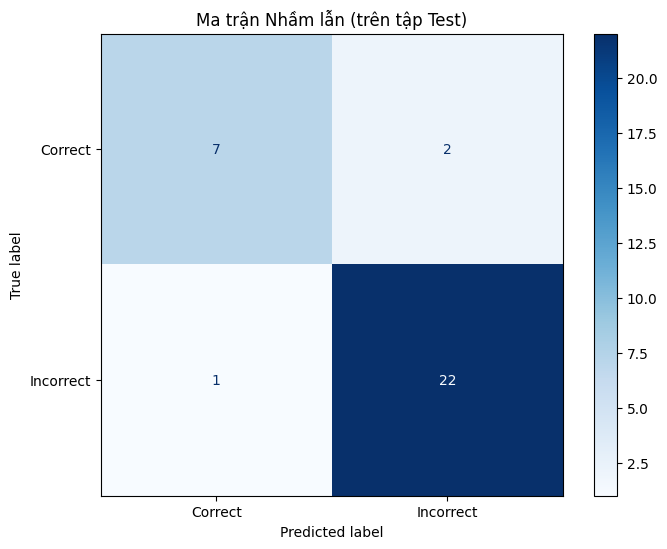

In [40]:
print("Đang huấn luyện mô hình RandomForestClassifier...")

# --- 1. Khởi tạo mô hình ---
# class_weight='balanced' có thể dùng thay thế/kết hợp với SMOTE
# nhưng ở đây ta đã dùng SMOTE nên không cần thiết
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# --- 2. Huấn luyện ---
# Huấn luyện trên dữ liệu đã resample
model.fit(X_train_res, y_train_res)

# --- 3. Dự đoán ---
# Đánh giá trên tập TEST gốc (chưa bao giờ thấy)
y_pred = model.predict(X_test)

print("\n--- Báo cáo Phân loại (Classification Report) ---")
# In ra báo cáo (chuyển 0, 1 về lại tên nhãn)
target_names = encoder.classes_
print(classification_report(y_test, y_pred, target_names=target_names))

# --- 4. Vẽ Ma trận Nhầm lẫn (Confusion Matrix) ---
print("Đang vẽ ma trận nhầm lẫn...")
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test,
    display_labels=target_names,
    cmap=plt.cm.Blues,
    ax=ax
)
ax.set_title("Ma trận Nhầm lẫn (trên tập Test)")
plt.show()

In [ ]:
print("Đang chuẩn bị cho việc tối ưu hyperparameter...")

# KHÔNG sử dụng X_train_res (đã SMOTE)
# Chúng ta sẽ đưa SMOTE vào pipeline và fit trên X_train, y_train GỐC
# 1. Định nghĩa các pipeline (SMOTE + Model)
# Lưu ý: k_neighbors của SMOTE phải nhỏ hơn số mẫu của lớp thiểu số
# trong fold nhỏ nhất. Đặt k_neighbors=3 cho an toàn.
pipe_rf = ImbPipeline([
    ('smote', SMOTE(random_state=42, k_neighbors=3)),
    ('model', RandomForestClassifier(random_state=42, n_jobs=-1))
])

pipe_svc = ImbPipeline([
    ('smote', SMOTE(random_state=42, k_neighbors=3)),
    ('model', SVC(random_state=42, probability=True))
])

pipe_xgb = ImbPipeline([
    ('smote', SMOTE(random_state=42, k_neighbors=3)),
    ('model', XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss'))
])

# 2. Định nghĩa lưới tham số (Param Grids) - (Giữ ở mức đơn giản để chạy nhanh)
# Tên tham số phải theo cú pháp: <tên_step>__<tên_tham_số>
param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20, None],
    'model__min_samples_leaf': [1, 2]
}

param_grid_svc = {
    'model__C': [0.1, 1.0, 10.0],
    'model__kernel': ['linear', 'rbf'],
    'model__gamma': ['scale', 'auto']
}

param_grid_xgb = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.01, 0.1],
    'model__max_depth': [3, 5, 7]
}

# 3. Tạo danh sách các trình tối ưu (GridSearch)
# Chúng ta dùng 'f1_weighted' làm scoring vì dữ liệu mất cân bằng
# cv=5 nghĩa là 5-fold cross-validation
gs_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
gs_svc = GridSearchCV(pipe_svc, param_grid_svc, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
gs_xgb = GridSearchCV(pipe_xgb, param_grid_xgb, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)

# Danh sách để lặp
grids = {
    "RandomForest": gs_rf,
    "SVM (SVC)": gs_svc,
    "XGBoost": gs_xgb
}

# 4. Huấn luyện (Đây có thể mất vài phút)
print("Bắt đầu huấn luyện và tối ưu 3 mô hình...")
print(f"Sử dụng {X_train.shape[0]} mẫu training GỐC (chưa SMOTE) cho 5-fold CV.")

best_estimators = {}
for name, gs in grids.items():
    print(f"\n--- Đang tối ưu {name} ---")
    start_time = time.time()
    
    gs.fit(X_train, y_train) # Fit trên dữ liệu GỐC
    
    end_time = time.time()
    print(f"Hoàn thành trong {end_time - start_time:.2f} giây.")
    
    print(f"Best F1-weighted score (CV): {gs.best_score_:.4f}")
    print(f"Best params: {gs.best_params_}")
    
    # Lưu lại mô hình (pipeline) tốt nhất
    best_estimators[name] = gs.best_estimator_

print("\n--- Tối ưu hoàn tất! ---")

Đang chuẩn bị cho việc tối ưu hyperparameter...
Bắt đầu huấn luyện và tối ưu 3 mô hình...
Sử dụng 128 mẫu training GỐC (chưa SMOTE) cho 5-fold CV.

--- Đang tối ưu RandomForest ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits


--- Đánh giá các mô hình đã tối ưu trên tập Test và Train ---

================= RandomForest ==================
--- Báo cáo trên TẬP TEST ---
              precision    recall  f1-score   support

     Correct       0.78      0.78      0.78         9
   Incorrect       0.91      0.91      0.91        23

    accuracy                           0.88        32
   macro avg       0.85      0.85      0.85        32
weighted avg       0.88      0.88      0.88        32

==> F1-Weighted (Test): 0.8750

==> F1-Weighted (Train): 1.0000


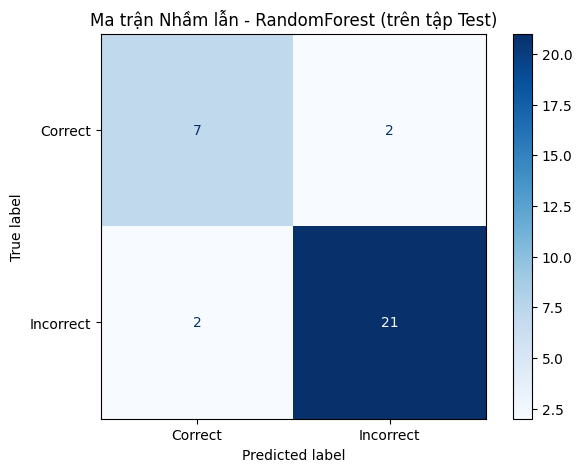


================= SVM (SVC) ==================
--- Báo cáo trên TẬP TEST ---
              precision    recall  f1-score   support

     Correct       0.73      0.89      0.80         9
   Incorrect       0.95      0.87      0.91        23

    accuracy                           0.88        32
   macro avg       0.84      0.88      0.85        32
weighted avg       0.89      0.88      0.88        32

==> F1-Weighted (Test): 0.8784

==> F1-Weighted (Train): 0.9313


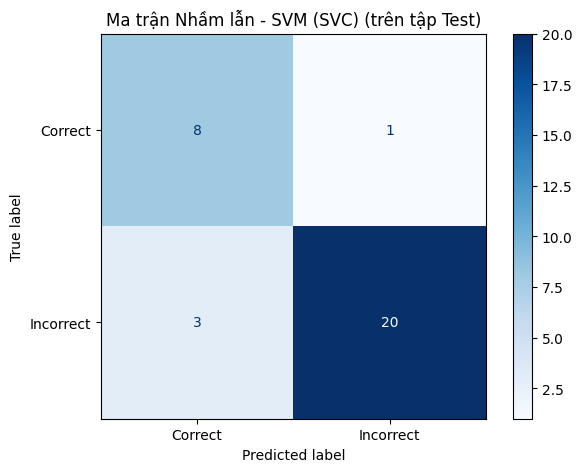


================= XGBoost ==================
--- Báo cáo trên TẬP TEST ---
              precision    recall  f1-score   support

     Correct       0.62      0.56      0.59         9
   Incorrect       0.83      0.87      0.85        23

    accuracy                           0.78        32
   macro avg       0.73      0.71      0.72        32
weighted avg       0.77      0.78      0.78        32

==> F1-Weighted (Test): 0.7771

==> F1-Weighted (Train): 1.0000


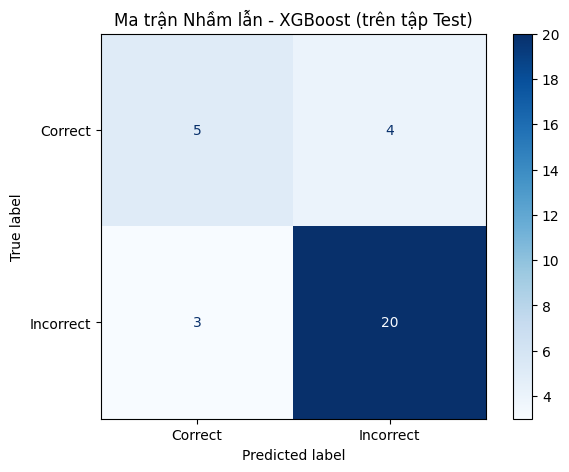


--- Đã hoàn thành đánh giá. Sẵn sàng vẽ biểu đồ so sánh ở Cell 13. ---


In [ ]:
print("--- Đánh giá các mô hình đã tối ưu trên tập Test và Train ---")

target_names = encoder.classes_ # (0=Correct, 1=Incorrect)

# Tạo một danh sách để lưu kết quả
model_scores_data = []

for name, model in best_estimators.items():
    print(f"\n================= {name} ==================")
    
    # --- 1. Đánh giá trên TẬP TEST ---
    y_pred_test = model.predict(X_test)
    test_score = f1_score(y_test, y_pred_test, average='weighted')
    
    print("--- Báo cáo trên TẬP TEST ---")
    print(classification_report(y_test, y_pred_test, target_names=target_names))
    print(f"==> F1-Weighted (Test): {test_score:.4f}")
    
    # --- 2. Đánh giá trên TẬP TRAIN ---
    # (Để kiểm tra overfitting)
    y_pred_train = model.predict(X_train)
    train_score = f1_score(y_train, y_pred_train, average='weighted')
    
    print(f"\n==> F1-Weighted (Train): {train_score:.4f}")
    
    # --- 3. Lưu điểm số ---
    model_scores_data.append({'Model': name, 'Set': 'Train', 'F1-Weighted': train_score})
    model_scores_data.append({'Model': name, 'Set': 'Test', 'F1-Weighted': test_score})

    # --- 4. Vẽ Ma trận Nhầm lẫn (Chỉ cho tập Test) ---
    fig, ax = plt.subplots(figsize=(7, 5))
    ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=target_names,
        cmap=plt.cm.Blues,
        ax=ax
    )
    ax.set_title(f"Ma trận Nhầm lẫn - {name} (trên tập Test)")
    plt.show()

# Chuyển danh sách kết quả thành DataFrame của Pandas
df_scores = pd.DataFrame(model_scores_data)

print("\n--- Đã hoàn thành đánh giá. Sẵn sàng vẽ biểu đồ so sánh ở Cell 13. ---")

--- So sánh hiệu năng Train vs. Test ---


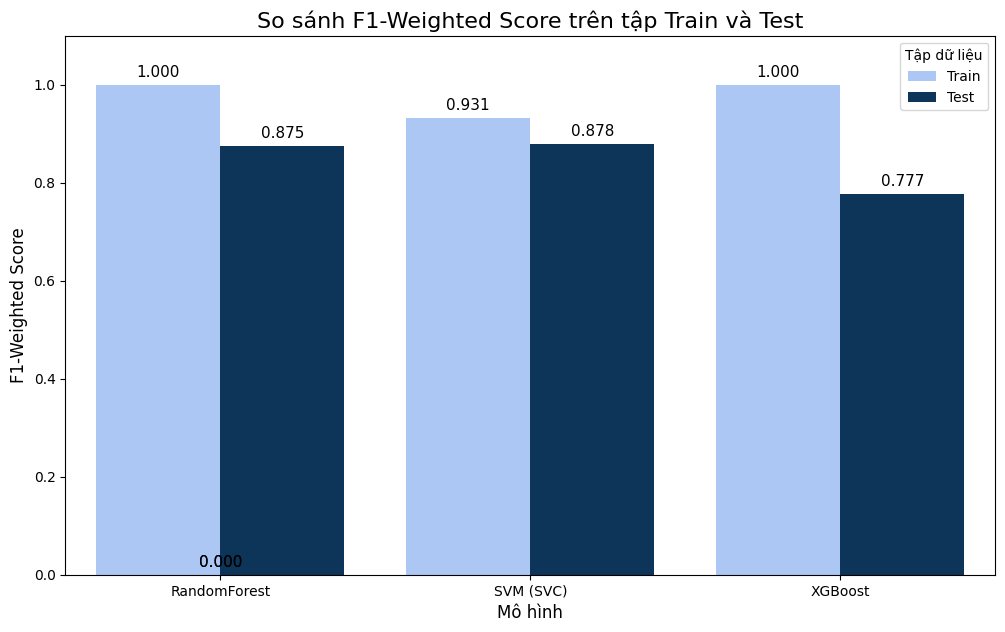


--- Phân tích Overfitting ---
📈 Một mô hình bị 'overfitting' (học vẹt) nếu cột 'Train' (xanh nhạt) RẤT CAO
   trong khi cột 'Test' (xanh đậm) THẤP HƠN ĐÁNG KỂ.
✅ Một khoảng cách nhỏ (ví dụ: Train 95% và Test 90%) là bình thường và tốt.
❌ Một khoảng cách lớn (ví dụ: Train 100% và Test 75%) là dấu hiệu của overfitting nặng.


In [ ]:
print("--- So sánh hiệu năng Train vs. Test ---")

plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=df_scores,
    x="Model",
    y="F1-Weighted",
    hue="Set", # Tạo 2 cột cho 'Train' và 'Test'
    palette={"Train": "#a0c4ff", "Test": "#003566"} # Xanh nhạt (Train), Xanh đậm (Test)
)

ax.set_title("So sánh F1-Weighted Score trên tập Train và Test", fontsize=16)
ax.set_xlabel("Mô hình", fontsize=12)
ax.set_ylabel("F1-Weighted Score", fontsize=12)
ax.set_ylim(0, 1.1) # Đặt trục y từ 0 -> 1.1 để dễ nhìn
ax.legend(title="Tập dữ liệu", loc='upper right')

# Thêm nhãn giá trị trên mỗi cột
for p in ax.patches:
    ax.annotate(f"{p.get_height():.3f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontsize=11)

plt.show()